# <ins>**Travaux pratique 1**</ins>
## <ins>Parcours des protons dans la matière</ins>
Importation de Modules utiles et définitions de certains termes.

In [83]:
from scipy.constants import Avogadro, c, m_e, m_p, e, physical_constants

from functools import partial
import pandas as pd
import sympy as sp
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt     #Permet de générer des graphiques.
import timeit

eV_to_MeV = 1e-6            #Convertion eV vers MeV.

m_p = m_p  * eV_to_MeV/e    # Masse du proton en MeV/c^2
m_e = m_e  * eV_to_MeV/e    # Masse de l'électron en MeV/c^2

r_e = physical_constants["classical electron radius"][0] * 1e2      # cm

<hr style="border-color:#D4D4D4">

## ***Question 1***
Exprimez la densité électronique $n_e$ d’un milieu en fonction de sa composition atomique et de sa masse volumique $\rho$, et calculer $n_e$ pour l’eau (liquide) et l’os compact (définition de l’ICRU). On s’appuiera sur les données du NIST pour les compositions atomiques de ces matériaux.

-------------VÉRIFIÉ_AVEC_AUTRE_ÉQUIPE_C'EST_GOOD--------------

In [84]:
n_e = lambda atomic_numbers, fractions_by_weight, rho, A: rho * Avogadro * np.sum(atomic_numbers * fractions_by_weight/A)

I_bone = 91.9 * eV_to_MeV                                                                                               # Mean Excitation Energy en MeV de l'eau liquide.
rho_bone = 1.85                                                                                                         # Densité de l'os Compact en g/cm^3
atomic_numbers_bone = np.array([1, 6, 7, 8, 12, 15, 16, 20])                                                            # Nombre atomique.
fractions_by_weight_bone = np.array([0.063984, 0.278000, 0.027000, 0.410016, 0.002000, 0.070000, 0.002000, 0.147000])   # Fractions Massiques.
AtomicMasses_bone = np.array([1.007975, 12.0106, 14.006855, 15.99940, 24.3055, 30.973762, 32.0675, 40.078])             # Masses Atomiques.

n_e_bone = n_e(atomic_numbers_bone, fractions_by_weight_bone, rho_bone, AtomicMasses_bone)                              # Densité électronique de l'Os Compact

I_water = 75 * eV_to_MeV                                                                                                # Mean Excitation Energy en MeV de l'eau liquide.
rho_water = 1                                                                                                           # Densité de l'eau liquide en g/cm^3
atomic_numbers_water = np.array([1, 8])                                                                                 # Nombre atomique.
fractions_by_weight_water = np.array([0.111894, 0.888106])                                                              # Fractions Massiques.
AtomicMasses_water = np.array([1.008, 15.999])                                                                          # Masses Atomiques.

n_e_water = n_e(atomic_numbers_water, fractions_by_weight_water, rho_water, AtomicMasses_water)                         # Densité électronique de l'eau liquide

print(f"Les densités électroniques de l'os compact et de l'eau liquide sont respectivement de {n_e_bone} e-/cm\u00b3 et {n_e_water} e-/cm\u00b3.")

Les densités électroniques de l'os compact et de l'eau liquide sont respectivement de 5.905891191511755e+23 e-/cm³ et 3.342810286137214e+23 e-/cm³.


<hr style="border-color:#D4D4D4">

## ***Question 2***
**<span style="color:#0C4504"><ins>Vérifié avec autre équipe, c'est good</ins></span>**

L’approximation d’une décélération continue (Continuous Slowing Down Approximation, CSDA) des protons dans la matière, en ligne droite, permet d’estimer leur portée dans le milieu considéré (la distance qu’ils peuvent parcourir avant d’avoir transféré au milieu la totalité de leur énergie cinétique initiale). Ici, seuls les transferts d’énergie vers les électrons du milieu sont considérés.

**Équation 9 :**
$$
T = (\gamma - 1) m_p c^2 \Rightarrow \gamma = \frac{T}{m_p c^2} + 1
$$
**Équation 10 :**
$$
\gamma = \frac{1}{\sqrt{1 - \beta^2}} \Rightarrow \gamma^2 \beta^2 = (\gamma^2 - 1)
$$


Certaines Équations sont utiles afin de faire ce problème :

**Équation 3:**
$$
T_e^{max} = \frac{2 m_e c^2 (\gamma^2 - 1)}{1 + 2 \gamma \frac{m_e}{m_p} + \left( \frac{m_e}{m_p} \right)^2}
$$
**Équation 4:**
$$
S_{col} = 2\pi r_e^2 m_e c^2 n_e \frac{1}{\beta^2} \big[\ln\big(\frac{2 m_e c^2 \beta^2 \lambda^2 T_e^{max}}{I^2}\big) - 2 \beta^2\big]
$$


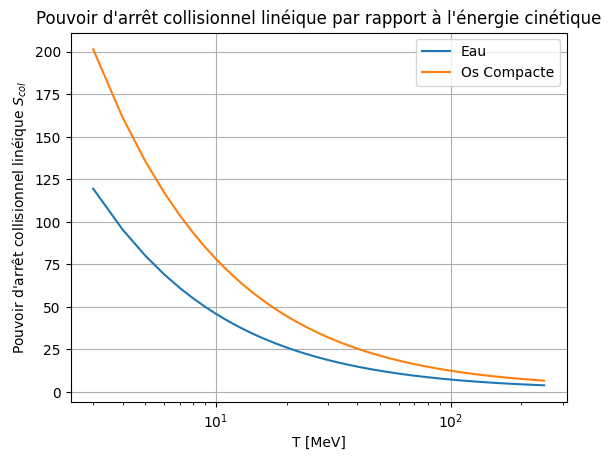

In [85]:
def gamma(T):   # Implémentation de l'équation 9.
    gamma = T/(m_p*c**2) + 1
    return gamma

def beta(T):    # implémentation de l'équation 10.
    beta = np.sqrt((gamma(T)**2 - 1)/gamma(T)**2)
    return beta

def t_max(T):   # implémentation de l'équation 3.
    t_max = (2*m_e*c**2 * (gamma(T)**2 - 1))/(1 + 2*(m_e/m_p)*gamma(T) + (m_e/m_p)**2)
    return t_max

def s_col(T, n_e, I_MeV):   # implémentation de l'équation 4.
    constant = 2 * np.pi * r_e**2 * m_e * c**2 * n_e
    s_col = constant * (1/beta(T)**2) * (np.log(2*m_e*c**2*beta(T)**2*t_max(T)/I_MeV**2) - 2*beta(T)**2)
    return s_col

SCol_bone = partial(s_col, n_e=n_e_bone, I_MeV=I_bone)      # définition du pouvoir d'arrêt collisionnel pour l'os compact.

SCol_water = partial(s_col, n_e=n_e_water, I_MeV=I_water)   # définition du pouvoir d'arrêt collisionnel pour l'eau liquide.

T = np.linspace(3, 250, 248)
S_col_water = SCol_water(T)     # Calcul du pouvoir d'arrêt collisionnel pour l'eau liquide.
S_col_bone = SCol_bone(T)       # Calcul du pouvoir d'arrêt collisionnel pour l'os compact.

#print(f"Kinetic energy T: {T}")
#print(f"Stopping Power S_col_bone: {S_col_bone} MeV/cm")
#print(f"Stopping Power S_col_water: {S_col_water} MeV/cm")
def plotit(T, bone=S_col_bone, water=S_col_water):      # Mise en graphique des pouvoirs d'arrêts.
    plt.plot(T, water, label="Eau")  # Tracé normal (pas semi-log sur X)
    plt.plot(T, bone, label="Os Compacte")
    plt.title("Pouvoir d'arrêt collisionnel linéique par rapport à l'énergie cinétique")  # Titre du graphique
    plt.xlabel("T [MeV]")
    plt.ylabel("Pouvoir d'arrêt collisionnel linéique $S_{col}$")
    plt.xscale('log')  # Axe des y en échelle logarithmique
    plt.legend()
    plt.grid()
    plt.show()

plotit(T)

<hr style="border-color:#D4D4D4">
<hr style="border-color:#D4D4D4">

# **Portée des protons dans la matière**
## ***Question 3***
Les données PSTAR sont données ici : https://physics.nist.gov/PhysRefData/Star/Text/PSTAR.html.
### <ins>Pour l'eau liquide:</ins>

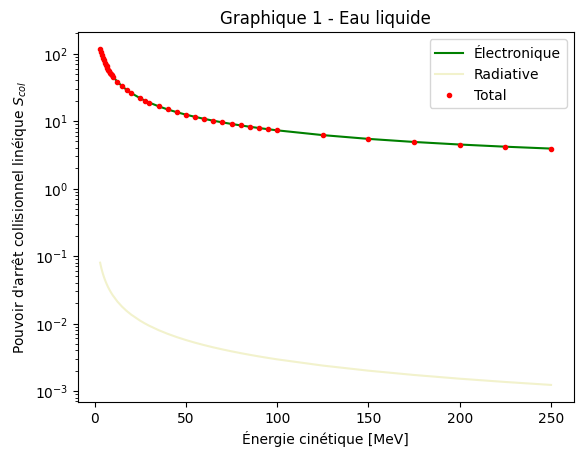

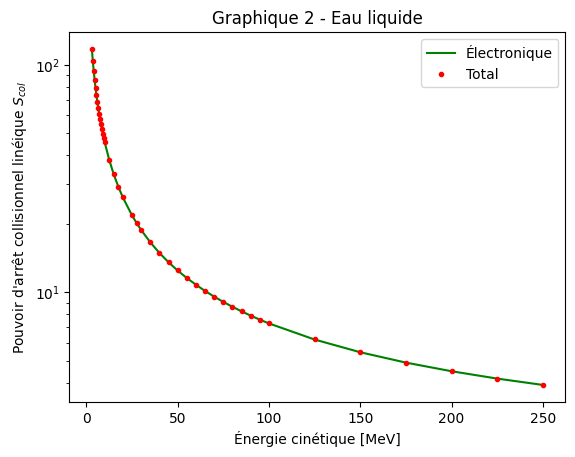

In [101]:
Ke_Mev_eau_liquide, \
Stopping_power_Electronic_eau_liquide, \
Stopping_power_Nuclear_eau_liquide, \
Stopping_power_total_eau_liquide = np.loadtxt("data_eau_liquide.txt", unpack=True)


plt.title("Graphique 1 - Eau liquide")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Electronic_eau_liquide,'g',label="Électronique")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Nuclear_eau_liquide, 'y', alpha=0.2,label="Radiative")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_total_eau_liquide, '.r',label="Total")
plt.xlabel("Énergie cinétique [MeV]")
plt.ylabel("Pouvoir d'arrêt collisionnel linéique $S_{col}$")
plt.legend()
plt.show()

plt.title("Graphique 2 - Eau liquide")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Electronic_eau_liquide, 'g',label="Électronique")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_total_eau_liquide, '.r',label="Total")
plt.xlabel("Énergie cinétique [MeV]")
plt.ylabel("Pouvoir d'arrêt collisionnel linéique $S_{col}$")
plt.legend()
plt.show()


### <ins>Pour l'os compact:</ins>

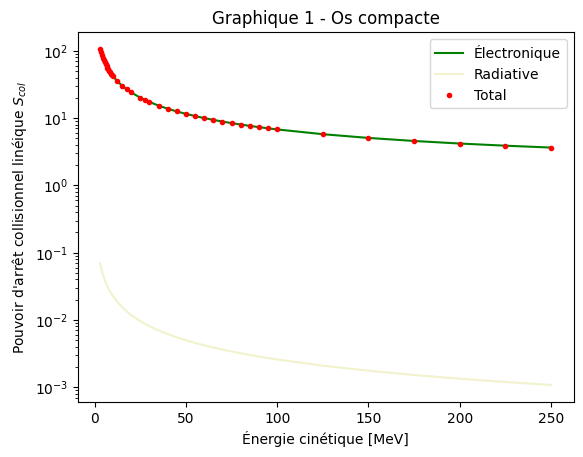

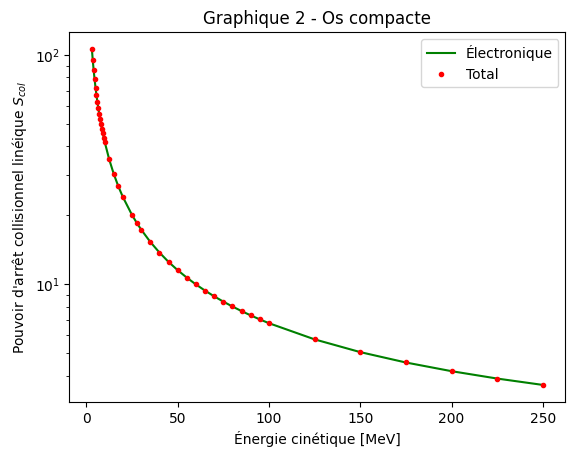

In [102]:
Ke_Mev_os_compact , \
Stopping_power_Electronic_os_compact, \
Stopping_power_Nuclear_os_compact, \
Stopping_power_total_os_compact = np.loadtxt("data_os_compact.txt", unpack=True)

plt.title("Graphique 1 - Os compacte")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_Electronic_os_compact,'g',label="Électronique")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_Nuclear_os_compact, 'y', alpha=0.2,label="Radiative")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_total_os_compact, '.r',label="Total")
plt.xlabel("Énergie cinétique [MeV]")
plt.ylabel("Pouvoir d'arrêt collisionnel linéique $S_{col}$")
plt.legend()
plt.show()

plt.title("Graphique 2 - Os compacte")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_Electronic_os_compact, 'g',label="Électronique")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_total_os_compact, '.r',label="Total")
plt.xlabel("Énergie cinétique [MeV]")
plt.ylabel("Pouvoir d'arrêt collisionnel linéique $S_{col}$")
plt.legend()
plt.show()

Il est possible de voir qu'il n'est pas nécessaire de considérer la contribution radiative. 

En effet, sa contribution est très minime comme on le voit aux Graphiques 1. Ces derniers montres les contributions des interactions nucléaires (Électroniques), les contributions radiatives, ainsi que le stopping power total. On remarque aux Graphiques 2 que le stopping power total et la contribution électronique sont presque identique. Cela prouve que la contribution radiative est négligeable. 

<hr style="border-color:#D4D4D4">

## ***Question 4***

À partir de l'équation suivante 
$ 
\frac{S_{col}}{\rho} = - \left( \frac{1}{\rho} \frac{dT}{dx} \right)_{col} 
$
on peut réexprimer dx en fonction du reste,
$$
dx = -\frac{dT}{S_{col}}
$$
On obtient ensuite,
$$ 
x = -\int^{T_i}_0 \frac{dT}{S_{col}}
$$

En prenant l'inverse du pouvoir d'arrêt, cela nous permet d'avoir les unités de longueurs par rapport de l'énergie. On intègre ensuite sur ces unités de longueurs pour obtenir l'entièreté de la porté.


<hr style="border-color:#D4D4D4">

## ***Question 5***


### **<span style="color:#700009"><ins>À améliorer:</ins></span>**
Équation complexe, il n’existe pas de solution analytique générale permettant de relier directement l’énergie initiale d’un proton à sa portée dans un milieu donné. $\frac{1}{\ln(x)}$ ne s'intègre pas.

<hr style="border-color:#D4D4D4">

## ***Question 6***

In [73]:
def Romberg(f, a, b, tol=np.finfo(float).eps,allR=False):
    def h(k):
        return (b - a) / (2 ** k)
    MAX_STEP = 40
    R = np.zeros((MAX_STEP, MAX_STEP))
    R[0, 0] = 0.5 * (b - a) * (f(a) + f(b))
    
    for n in range(1, MAX_STEP):
        h_n = h(n)
        midpoints = np.array([a + (2 * k - 1) * h_n for k in range(1, 2 ** (n-1) + 1)])
        R[n, 0] = 0.5 * R[n - 1, 0] + h_n * np.sum(f(midpoints))
        for m in range(1, n + 1):
            R[n, m] = (4 ** m * R[n, m - 1] - R[n - 1, m - 1]) / (4 ** m - 1)

        if abs(R[n, n] - R[n - 1, n - 1]) <= tol:
            print(f"nombre de slice: {2**n}")
            if allR:
                return R
            return R[n, n]
    if allR:
        return R
    return R[n, n]

def trapz(f,a,b,tol=np.finfo(float).eps, TRY=10, allR=False):
    I = 0.5 * (b - a) * (f(a) + f(b)) # un seul trapèze
    h_n = (b - a)/2
    R = np.zeros(TRY)
    R[0] = I
    for n in range(1, TRY):
        h_n /= 2
        sum_midpoints = np.sum(f(np.linspace(a + h_n, b - h_n, 2**(n))))
        new_I = 0.5 * I + h_n * sum_midpoints
        R[n] = new_I
        error_estimate = abs(I - new_I) / 3
        if error_estimate <= tol:
            print("convergence sous la précision machine")
            print(f"nombre de slice: {2**n}", new_I)
            if allR:
                return R
            return new_I
        I = new_I
    print(f"nombre de slice: {2**TRY}, error estimate: {error_estimate}")
    if allR:
        return R
    return I

In [ ]:
def inverse(func):
    def wrapper(*args):
        res = func(*args)
        return 1/res
    return wrapper

### <ins>Os compacte:</ins>

In [57]:
Romberg(inverse(SCol_bone), 3, 150)

nombre de slice: 8192


9.276753933580995

In [58]:
trapz(inverse(SCol_bone), 3, 150,TRY=20)

nombre de slice: 1048576, error estimate: 4.2254743348735246e-07


9.276752665941153

### <ins>Eau liquide:</ins>

In [59]:
Romberg(inverse(SCol_water), 3, 150)

nombre de slice: 16384


15.949473968874871

In [60]:
trapz(inverse(SCol_water), 3, 150,TRY=20)

nombre de slice: 1048576, error estimate: 7.222149870737363e-07


15.949471802234086

<hr style="border-color:#D4D4D4">

## ***Question 7***
Tracez un graphique de la portée calculée par chaque méthode en fonction du nombre d’échantillons (de tranches) considéré. Le même graphique rapportera l’estimation pratique de l’erreur d’approximation pour les deux méthodes (avec une échelle différente en ordonnée). Votre graphique comprendra des points choisis de façon à bien représenter le comportement de vos algorithmes (des échelles logarithmiques pourraient être nécessaires). Doubler le nombre de tranches entre chaque évaluation pourrait s’avérer judicieux.

### <ins>Os compacte et eau liquide</ins>

In [74]:
def getNRes(R):
    res = np.diag(R)
    res = res[res!=0]
    N = [2**i for i in range(res.shape[0])]
    return N, res

nombre de slice: 8192
nombre de slice: 16384
nombre de slice: 1048576, error estimate: 4.2254743348735246e-07
nombre de slice: 1048576, error estimate: 7.222149870737363e-07


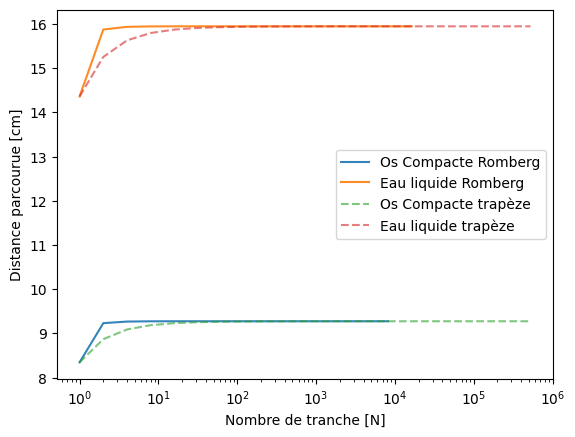

In [75]:
plt.semilogx(*getNRes(Romberg(inverse(SCol_bone), 3, 150, allR=True)), "-",label="Os Compacte Romberg", alpha=0.9)
plt.semilogx(*getNRes(Romberg(inverse(SCol_water), 3, 150, allR=True)), "-",label="Eau liquide Romberg", alpha=0.9)
plt.semilogx(*getNRes(trapz(inverse(SCol_bone), 3, 150, TRY=20,allR=True)), "--",label="Os Compacte trapèze", alpha=0.6)
plt.semilogx(*getNRes(trapz(inverse(SCol_water), 3, 150, TRY=20,allR=True)), "--",label="Eau liquide trapèze", alpha=0.6)

plt.legend()
plt.xlabel("Nombre de tranche [N]")
plt.ylabel("Distance parcourue [cm]")
plt.show()

<hr style="border-color:#D4D4D4">
<hr style="border-color:#D4D4D4">

# **Estimation analytique de l'erreur** 
**À faire pour la Q7**

## ***Question 8***
la dérivé de $ S^{-1}_{col}$, selon mon calcul à la main est : $$  \frac{d S^{-1}_{col}}{dT} = \frac{-1}{2\pi r_e^2 m_e c^4 n_e m_p } 
\left( \frac{\left(\frac{-2\gamma^3}{(\gamma^2 - 1)^2} + \frac{2\gamma}{\gamma^2 -1}\right) 
\ln \left(\frac{a^2(\gamma^2 -1)^2}{I^2 (b+\delta \gamma)}\right) + \frac{1}{\gamma^2 -1} \left( 4\gamma -\frac{\delta}{b+\delta \gamma}\right) }{\left[ \ln \left(\frac{a^2(\gamma^2 -1)^2}{I^2 (b+\delta \gamma)}\right) \frac{\gamma^2}{\gamma^2 -1} -2\right]^2}\right)$$

In [76]:
# Define symbols
T = sp.Symbol('T', real=True, positive=True)  # Temperature
ne = sp.Symbol('n_e', real=True, positive=True)  # Electron number density
IMeV = sp.Symbol('I_{MeV}', real=True, positive=True)  # Ionization energy in MeV
re = sp.Symbol('r_e', real=True, positive=True)  # Classical electron radius
me = sp.Symbol('m_e', real=True, positive=True)  # Electron mass
mp = sp.Symbol('m_p', real=True, positive=True)  # Proton mass
c = sp.Symbol('c', real=True, positive=True)  # Speed of light

# Define gamma factor
gamma = T / (mp * c**2) + 1

# Define T_max
T_max = (2 * me * c**2 * (gamma**2 - 1)) / (1 + 2 * (me / mp) * gamma + (me / mp)**2)

# Define beta
beta = 1 / (gamma**2 / (gamma**2 - 1))

# Define U
U = 2 * sp.pi * re**2 * me * c**2 * ne

# Define S_col expression
S_col = U / (beta**2) * (sp.log((2 * me * c**2 * beta**2 * gamma**2 * T_max) / IMeV**2) - 2 * beta**2)

# Display the expression


In [77]:
f = S_col**-1

In [78]:
f = sp.simplify(f)

In [79]:
dfdT = sp.diff(f,T)

In [80]:
dfdT = sp.together(dfdT)

<hr style="border-color:#D4D4D4">

## ***Question 9***

<hr style="border-color:#D4D4D4">
<hr style="border-color:#D4D4D4">

# **Optimisation**
## ***Question 10***

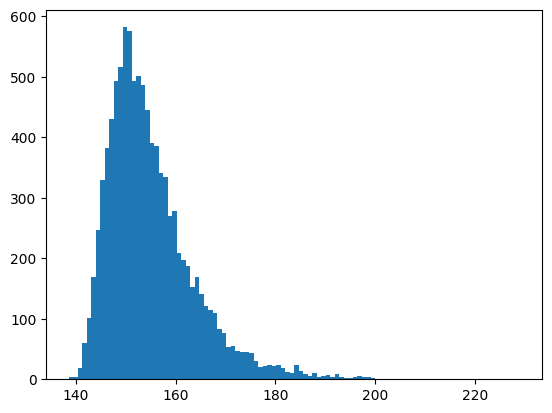

In [81]:
energy_proton = scipy.stats.moyal.rvs(loc=150, scale=4, size=10000)

plt.hist(energy_proton, bins=100)
plt.show()


<hr style="border-color:#D4D4D4">

## ***Question 11***

<hr style="border-color:#D4D4D4">

## ***Question 12***

<hr style="border-color:#D4D4D4">
<hr style="border-color:#D4D4D4">

# **Énergie déposée**
## ***Question 13***

<hr style="border-color:#D4D4D4">

## ***Question 14***

<hr style="border-color:#D4D4D4">

## ***Question 15***

<hr style="border-color:#D4D4D4">

## ***Question 16***

<hr style="border-color:#D4D4D4">

## ***Question 17***